In [1]:
import commot as ct
import scanpy as sc
import pandas as pd
import numpy as np
from pathlib import Path, PurePath
from typing import Union, Dict, Optional, Tuple, BinaryIO, Literal

import h5py
import json
import numpy as np
import pandas as pd
from matplotlib.image import imread
import anndata
from anndata import (
    AnnData,
    read_csv,
    read_text,
    read_excel,
    read_mtx,
    read_loom,
    read_hdf,
)
from anndata import read as read_h5ad
def read_visium(
    path: Union[str, Path],
    genome: Optional[str] = None,
    *,
    count_file: str = "filtered_feature_bc_matrix.h5",
    library_id: Optional[str] = None,
    load_images: Optional[bool] = True,
    source_image_path: Optional[Union[str, Path]] = None,
) -> AnnData:

    path = Path(path)
    adata = sc.read_10x_h5(path / count_file, genome=genome)

    adata.uns["spatial"] = dict()

    from h5py import File

    with File(path / count_file, mode="r") as f:
        attrs = dict(f.attrs)
    if library_id is None:
        library_id = str(attrs.pop("library_ids")[0], "utf-8")

    adata.uns["spatial"][library_id] = dict()

    if load_images:
        tissue_positions_file = (
            path / "spatial/tissue_positions.csv"
            if (path / "spatial/tissue_positions.csv").exists()
            else path / "spatial/tissue_positions.csv"
        )
        files = dict(
            tissue_positions_file=tissue_positions_file,
            scalefactors_json_file=path / "spatial/scalefactors_json.json",
            hires_image=path / "spatial/tissue_hires_image.png",
            lowres_image=path / "spatial/tissue_lowres_image.png",
        )

        # check if files exists, continue if images are missing
        for f in files.values():
            if not f.exists():
                if any(x in str(f) for x in ["hires_image", "lowres_image"]):
                    logg.warning(
                        f"You seem to be missing an image file.\n"
                        f"Could not find '{f}'."
                    )
                else:
                    raise OSError(f"Could not find '{f}'")

        adata.uns["spatial"][library_id]["images"] = dict()
        for res in ["hires", "lowres"]:
            try:
                adata.uns["spatial"][library_id]["images"][res] = imread(
                    str(files[f"{res}_image"])
                )
            except Exception:
                raise OSError(f"Could not find '{res}_image'")

        # read json scalefactors
        adata.uns["spatial"][library_id]["scalefactors"] = json.loads(
            files["scalefactors_json_file"].read_bytes()
        )

        adata.uns["spatial"][library_id]["metadata"] = {
            k: (str(attrs[k], "utf-8") if isinstance(attrs[k], bytes) else attrs[k])
            for k in ("chemistry_description", "software_version")
            if k in attrs
        }

        # read coordinates
        positions = pd.read_csv(
            files["tissue_positions_file"],
            header=1 if tissue_positions_file.name == "tissue_positions.csv" else None,
            index_col=0,
        )
        positions.columns = [
            "in_tissue",
            "array_row",
            "array_col",
            "pxl_col_in_fullres",
            "pxl_row_in_fullres",
        ]

        adata.obs = adata.obs.join(positions, how="left")

        adata.obsm["spatial"] = adata.obs[
            ["pxl_row_in_fullres", "pxl_col_in_fullres"]
        ].to_numpy()
        adata.obs.drop(
            columns=["pxl_row_in_fullres", "pxl_col_in_fullres"],
            inplace=True,
        )

        # put image path in uns
        if source_image_path is not None:
            # get an absolute path
            source_image_path = str(Path(source_image_path).resolve())
            adata.uns["spatial"][library_id]["metadata"]["source_image_path"] = str(
                source_image_path
            )

    return adata


In [2]:
N_1 = read_visium('/ix1/wchen/Shiyue/Projects/2023_06_Influ_Mouse_Lung_ST/RawData/SpaceRanger_output/01_WT_Naive/outs')
N_2 = read_visium('/ix1/wchen/Shiyue/Projects/2023_06_Influ_Mouse_Lung_ST/RawData/SpaceRanger_output/02_WT_Naive/outs')
S_1 = read_visium('/ix1/wchen/liutianhao/result/03_WT_SA_Only_2/outs/')
S_2 = read_visium('/ix1/wchen/liutianhao/result/05_WT_SA_Only_2/outs/')
F_1 = read_visium('/ix1/wchen/Shiyue/Projects/2023_06_Influ_Mouse_Lung_ST/RawData/SpaceRanger_output/06_WT_Flu_Only/outs')
F_2 = read_visium('/ix1/wchen/Shiyue/Projects/2023_06_Influ_Mouse_Lung_ST/RawData/SpaceRanger_output/07_WT_Flu_Only/outs')
FS_1 = read_visium('/ix1/wchen/Shiyue/Projects/2023_06_Influ_Mouse_Lung_ST/RawData/SpaceRanger_output/08_WT_F_S/outs')
FS_2 = read_visium('/ix1/wchen/Shiyue/Projects/2023_06_Influ_Mouse_Lung_ST/RawData/SpaceRanger_output/09_WT_F_S/outs')
N_1.var_names_make_unique()
N_2.var_names_make_unique()
S_1.var_names_make_unique()
S_2.var_names_make_unique()
F_1.var_names_make_unique()
F_2.var_names_make_unique()
FS_1.var_names_make_unique()
FS_2.var_names_make_unique()

In [3]:
def preprocess(object):
    object.raw = object
    sc.pp.normalize_total(object, inplace=True)
    sc.pp.log1p(object)
    return object

In [4]:
import anndata as ad
combine = ad.concat([N_1, N_2, S_1, S_2, F_1, F_2, FS_1, FS_2], join="inner")

In [5]:
combine.var_names_make_unique()
combine.raw = combine
sc.pp.normalize_total(combine, inplace=True)
sc.pp.log1p(combine)
combine_dis500 = combine.copy()

In [85]:
N_1 = preprocess(N_1)
N_2 = preprocess(N_2)
S_1 = preprocess(S_1)
S_2 = preprocess(S_2)
F_1 = preprocess(F_1)
F_2 = preprocess(F_2)
FS_1 = preprocess(FS_1)
FS_2 = preprocess(FS_2)

In [6]:
#df_cellchat = ct.pp.ligand_receptor_database(species='mouse', signaling_type=None, database='CellChat')
df_cellchat = ct.pp.ligand_receptor_database(species='mouse', signaling_type=None, database='CellChat')
print(df_cellchat.shape)

(2019, 4)


In [7]:
#original 0.05
df_cellchat_filtered = ct.pp.filter_lr_database(df_cellchat, combine, min_cell_pct=0.05)
print(df_cellchat_filtered.shape)

(1367, 4)


In [11]:
#add extra interesting lr pairs
df_cellchat_extra = df_cellchat[(df_cellchat.iloc[:,1]== 'Icos')|(df_cellchat.iloc[:,1]== 'Cxcr5')|(df_cellchat.iloc[:,1]== 'Cd40')|(df_cellchat.iloc[:,2]== 'MHC-II')|(df_cellchat.iloc[:,2]== 'IFN-I')]

In [12]:
df_cellchat_filtered.columns = df_cellchat.columns

In [13]:
df_cellchat_filtered = pd.concat([df_cellchat_extra, df_cellchat_filtered]).drop_duplicates().reset_index(drop=True)

In [ ]:
ct.tl.spatial_communication(FS_1,
    database_name='cellchat', df_ligrec=df_cellchat_filtered, dis_thr=500, heteromeric=True, pathway_sum=True)
FS_1.write_h5ad('/ix1/wchen/liutianhao/result/lung_ST/alcorn/script/commo_result/FS_1_commot.h5ad')

In [ ]:
ct.tl.spatial_communication(FS_2,
    database_name='cellchat', df_ligrec=df_cellchat_filtered, dis_thr=500, heteromeric=True, pathway_sum=True)
FS_2.write_h5ad('/ix1/wchen/liutianhao/result/lung_ST/alcorn/script/commo_result/FS_2_commot.h5ad')

In [ ]:
ct.tl.spatial_communication(S_1,
    database_name='cellchat', df_ligrec=df_cellchat_filtered, dis_thr=500, heteromeric=True, pathway_sum=True)
S_1.write_h5ad('/ix1/wchen/liutianhao/result/lung_ST/alcorn/script/commo_result/S_1_commot.h5ad')

In [ ]:
ct.tl.spatial_communication(S_2,
    database_name='cellchat', df_ligrec=df_cellchat_filtered, dis_thr=500, heteromeric=True, pathway_sum=True)
S_2.write_h5ad('/ix1/wchen/liutianhao/result/lung_ST/alcorn/script/commo_result/S_2_commot.h5ad')

In [ ]:
ct.tl.spatial_communication(N_1,
    database_name='cellchat', df_ligrec=df_cellchat_filtered, dis_thr=500, heteromeric=True, pathway_sum=True)
N_1.write_h5ad('/ix1/wchen/liutianhao/result/lung_ST/alcorn/script/commo_result/N_1_commot.h5ad')

In [ ]:
ct.tl.spatial_communication(N_2,
    database_name='cellchat', df_ligrec=df_cellchat_filtered, dis_thr=500, heteromeric=True, pathway_sum=True)
N_2.write_h5ad('/ix1/wchen/liutianhao/result/lung_ST/alcorn/script/commo_result/N_2_commot.h5ad')

In [ ]:
ct.tl.spatial_communication(F_1,
    database_name='cellchat', df_ligrec=df_cellchat_filtered, dis_thr=500, heteromeric=True, pathway_sum=True)
F_1.write_h5ad('/ix1/wchen/liutianhao/result/lung_ST/alcorn/script/commo_result/F_1_commot.h5ad')

In [ ]:
ct.tl.spatial_communication(F_2,
    database_name='cellchat', df_ligrec=df_cellchat_filtered, dis_thr=500, heteromeric=True, pathway_sum=True)
F_2.write_h5ad('/ix1/wchen/liutianhao/result/lung_ST/alcorn/script/commo_result/F_2_commot.h5ad')

In [2]:
N_1 = sc.read_h5ad('/ix1/wchen/liutianhao/result/lung_ST/result/N_1_commot3.h5ad')
N_2 = sc.read_h5ad('/ix1/wchen/liutianhao/result/lung_ST/result/N_3_commot3.h5ad')
F_1 = sc.read_h5ad('/ix1/wchen/liutianhao/result/lung_ST/result/F_1_commot3.h5ad')
F_2 = sc.read_h5ad('/ix1/wchen/liutianhao/result/lung_ST/result/F_2_commot3.h5ad')
S_1 = sc.read_h5ad('/ix1/wchen/liutianhao/result/lung_ST/result/S_1_commot3.h5ad')
S_2 = sc.read_h5ad('/ix1/wchen/liutianhao/result/lung_ST/result/S_2_commot3.h5ad')
FS_1 = sc.read_h5ad('/ix1/wchen/liutianhao/result/lung_ST/result/FS_1_commot3.h5ad')
FS_2 = sc.read_h5ad('/ix1/wchen/liutianhao/result/lung_ST/result/FS_2_commot3.h5ad')

In [14]:
pd.DataFrame(N_1.obsp['commot-cellchat-total-total'].toarray()).to_csv('/ix1/wchen/liutianhao/result/lung_ST/alcorn/adjacency/N_1.csv')
pd.DataFrame(N_2.obsp['commot-cellchat-total-total'].toarray()).to_csv('/ix1/wchen/liutianhao/result/lung_ST/alcorn/adjacency/N_2.csv')
pd.DataFrame(S_1.obsp['commot-cellchat-total-total'].toarray()).to_csv('/ix1/wchen/liutianhao/result/lung_ST/alcorn/adjacency/S_1.csv')
pd.DataFrame(S_2.obsp['commot-cellchat-total-total'].toarray()).to_csv('/ix1/wchen/liutianhao/result/lung_ST/alcorn/adjacency/S_2.csv')
pd.DataFrame(F_1.obsp['commot-cellchat-total-total'].toarray()).to_csv('/ix1/wchen/liutianhao/result/lung_ST/alcorn/adjacency/F_1.csv')
pd.DataFrame(F_2.obsp['commot-cellchat-total-total'].toarray()).to_csv('/ix1/wchen/liutianhao/result/lung_ST/alcorn/adjacency/F_2.csv')
pd.DataFrame(FS_1.obsp['commot-cellchat-total-total'].toarray()).to_csv('/ix1/wchen/liutianhao/result/lung_ST/alcorn/adjacency/FS_1.csv')
pd.DataFrame(FS_2.obsp['commot-cellchat-total-total'].toarray()).to_csv('/ix1/wchen/liutianhao/result/lung_ST/alcorn/adjacency/FS_2.csv')

In [23]:
pd.DataFrame(N_1.obs_names).to_csv('/ix1/wchen/liutianhao/result/lung_ST/alcorn/adjacency/N_1_name.csv')
pd.DataFrame(N_2.obs_names).to_csv('/ix1/wchen/liutianhao/result/lung_ST/alcorn/adjacency/N_2_name.csv')
pd.DataFrame(S_1.obs_names).to_csv('/ix1/wchen/liutianhao/result/lung_ST/alcorn/adjacency/S_1_name.csv')
pd.DataFrame(S_2.obs_names).to_csv('/ix1/wchen/liutianhao/result/lung_ST/alcorn/adjacency/S_2_name.csv')
pd.DataFrame(F_1.obs_names).to_csv('/ix1/wchen/liutianhao/result/lung_ST/alcorn/adjacency/F_1_name.csv')
pd.DataFrame(F_2.obs_names).to_csv('/ix1/wchen/liutianhao/result/lung_ST/alcorn/adjacency/F_2_name.csv')
pd.DataFrame(FS_1.obs_names).to_csv('/ix1/wchen/liutianhao/result/lung_ST/alcorn/adjacency/FS_1_name.csv')
pd.DataFrame(FS_2.obs_names).to_csv('/ix1/wchen/liutianhao/result/lung_ST/alcorn/adjacency/FS_2_name.csv')

In [5]:
ct.tl.communication_direction(F_1, database_name='cellchat', pathway_name='Cxcl13-Cxcr5', k=5)
ct.tl.communication_direction(F_2, database_name='cellchat', pathway_name='Cxcl13-Cxcr5', k=5)
ct.tl.communication_direction(FS_1, database_name='cellchat', pathway_name='Cxcl13-Cxcr5', k=5)
ct.tl.communication_direction(FS_2, database_name='cellchat', pathway_name='Cxcl13-Cxcr5', k=5)


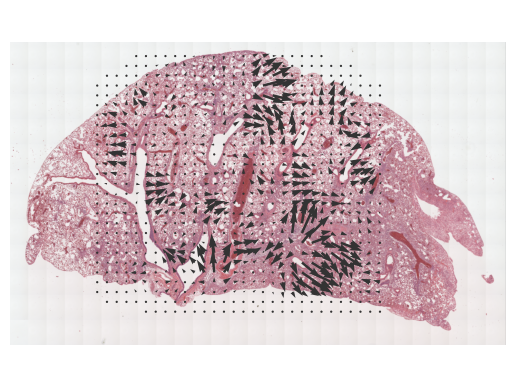

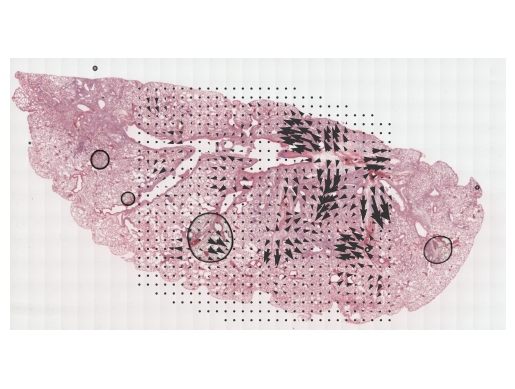

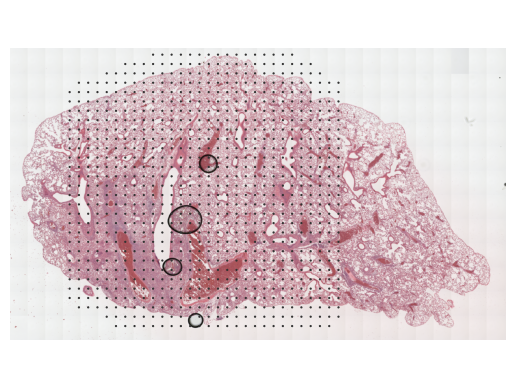

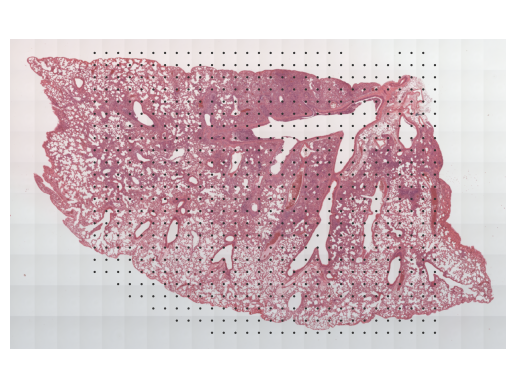

In [36]:
ct.pl.plot_cell_communication(F_1, database_name='cellchat', pathway_name='Cxcl13-Cxcr5', plot_method='grid', background_legend=True,
    scale=0.00007, ndsize=5, grid_density=0.6, summary='sender', background='image', clustering='label', cmap='Alphabet',
    normalize_v = True, normalize_v_quantile=0.76)
plt.savefig("commot_figure_F_1.png", dpi=400, bbox_inches="tight")  # High-resolution PNG


ct.pl.plot_cell_communication(F_2, database_name='cellchat', pathway_name='Cxcl13-Cxcr5', plot_method='grid', background_legend=True,
    scale=0.00007, ndsize=5, grid_density=0.6, summary='sender', background='image', clustering='label', cmap='Alphabet',
    normalize_v = True, normalize_v_quantile=0.82)
plt.savefig("commot_figure_F_2.png", dpi=400, bbox_inches="tight")  # High-resolution PNG


ct.pl.plot_cell_communication(FS_1, database_name='cellchat', pathway_name='Cxcl13-Cxcr5', plot_method='grid', background_legend=True,
    scale=0.00007, ndsize=5, grid_density=0.6, summary='sender', background='image', clustering='label', cmap='Alphabet',
    normalize_v = True, normalize_v_quantile=0.995)
plt.savefig("commot_figure_FS_1.png", dpi=400, bbox_inches="tight")  # High-resolution PNG


ct.pl.plot_cell_communication(FS_2, database_name='cellchat', pathway_name='Cxcl13-Cxcr5', plot_method='grid', background_legend=True,
    scale=0.00007, ndsize=5, grid_density=0.6, summary='sender', background='image', clustering='label', cmap='Alphabet',
    normalize_v = True, normalize_v_quantile=0.995)
plt.savefig("commot_figure_FS_2.png", dpi=400, bbox_inches="tight")  # High-resolution PNG


<Axes: >

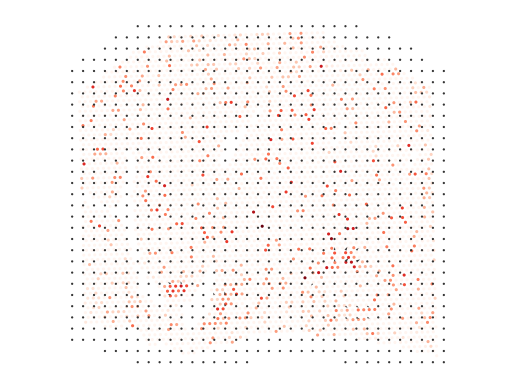

In [72]:
ct.pl.plot_cell_communication(F_1, database_name='cellchat', pathway_name='Cxcl13-Cxcr5', plot_method='grid', background_legend=True,
    scale=0.00007, ndsize=5, grid_density=0.7, summary='receiver', background='summary', clustering='leiden', cmap='Reds',
    normalize_v = False, normalize_v_quantile=0.83)


<Axes: >

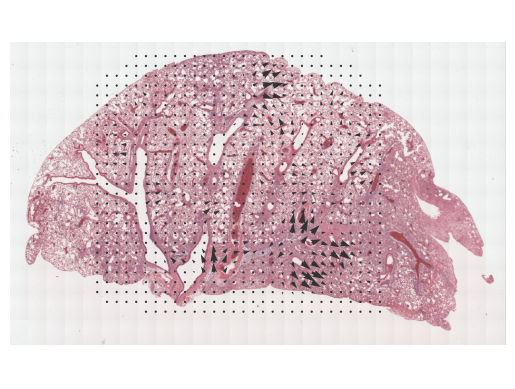

In [41]:
ct.tl.communication_direction(F_1, database_name='cellchat', pathway_name='Cxcl13-Cxcr5', k=5)
ct.pl.plot_cell_communication(F_1, database_name='cellchat', pathway_name='Cxcl13-Cxcr5', plot_method='grid', background_legend=True,
    scale=0.00003, ndsize=8, grid_density=0.6, summary='sender', background='image', clustering='leiden', cmap='Reds',
    normalize_v = True, normalize_v_quantile=0.9)

In [6]:
N_1.obsm['commot-cellchat-sum-receiver'].to_csv('/ix1/wchen/liutianhao/result/lung_ST/result/recie4_N_1.csv')
N_2.obsm['commot-cellchat-sum-receiver'].to_csv('/ix1/wchen/liutianhao/result/lung_ST/result/recie4_N_2.csv')
S_1.obsm['commot-cellchat-sum-receiver'].to_csv('/ix1/wchen/liutianhao/result/lung_ST/result/recie4_S_1.csv')
S_2.obsm['commot-cellchat-sum-receiver'].to_csv('/ix1/wchen/liutianhao/result/lung_ST/result/recie4_S_2.csv')
F_1.obsm['commot-cellchat-sum-receiver'].to_csv('/ix1/wchen/liutianhao/result/lung_ST/result/recie4_F_1.csv')
F_2.obsm['commot-cellchat-sum-receiver'].to_csv('/ix1/wchen/liutianhao/result/lung_ST/result/recie4_F_2.csv')
FS_1.obsm['commot-cellchat-sum-receiver'].to_csv('/ix1/wchen/liutianhao/result/lung_ST/result/recie4_FS_1.csv')
FS_2.obsm['commot-cellchat-sum-receiver'].to_csv('/ix1/wchen/liutianhao/result/lung_ST/result/recie4_FS_2.csv')

In [7]:
N_1.obsm['commot-cellchat-sum-sender'].to_csv('/ix1/wchen/liutianhao/result/lung_ST/result/send4_N_1.csv')
N_2.obsm['commot-cellchat-sum-sender'].to_csv('/ix1/wchen/liutianhao/result/lung_ST/result/send4_N_2.csv')
S_1.obsm['commot-cellchat-sum-sender'].to_csv('/ix1/wchen/liutianhao/result/lung_ST/result/send4_S_1.csv')
S_2.obsm['commot-cellchat-sum-sender'].to_csv('/ix1/wchen/liutianhao/result/lung_ST/result/send4_S_2.csv')
F_1.obsm['commot-cellchat-sum-sender'].to_csv('/ix1/wchen/liutianhao/result/lung_ST/result/send4_F_1.csv')
F_2.obsm['commot-cellchat-sum-sender'].to_csv('/ix1/wchen/liutianhao/result/lung_ST/result/send4_F_2.csv')
FS_1.obsm['commot-cellchat-sum-sender'].to_csv('/ix1/wchen/liutianhao/result/lung_ST/result/send4_FS_1.csv')
FS_2.obsm['commot-cellchat-sum-sender'].to_csv('/ix1/wchen/liutianhao/result/lung_ST/result/send4_FS_2.csv')